# 10 minutes to Pingouin

## 1. T-test

In [1]:
import numpy as np
import pandas as pd
import pingouin as pg

np.random.seed(123)
mean, cov, n = [4, 5], [(1, .6), (.6, 1)], 30
x, y = np.random.multivariate_normal(mean, cov, n).T

# T-test
pg.ttest(x, y)

,T,p-val,dof,tail,cohen-d,power,BF10
T-test,-3.401,0.001222,58,two-sided,0.878,0.917,26.155


## 2. Pearson's correlation

In [2]:
pg.corr(x, y)

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,30,0.595,"[0.3, 0.79]",0.354,0.306,0.000527,54.222,0.95


## 3. Robust correlation

In [3]:
# Introduce an outlier
x[5] = 18
# Use the robust Shepherd's pi correlation
pg.corr(x, y, method="shepherd")

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
shepherd,30,1,0.561,"[0.25, 0.77]",0.315,0.264,0.001543,0.917


## 4. Test the normality of the data

In [4]:
# Return a boolean (true if normal) and the associated p-value
print(pg.normality(x, y))                                 # Univariate normality
print(pg.multivariate_normality(np.column_stack((x, y)))) # Multivariate normality

(array([False,  True]), array([0.   , 0.552]))
(False, 0.00018201726664169367)


## 5. One-way ANOVA using a pandas DataFrame

In [5]:
# Read an example dataset
from pingouin.datasets import read_dataset
df = read_dataset('mixed_anova')

# Run the ANOVA
aov = pg.anova(data=df, dv='Scores', between='Group', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Group,5.460,1,5.460,5.244,0.0232003,0.029
1,Within,185.343,178,1.041,-,-,-


## 6. Repeated measures ANOVA

In [6]:
pg.rm_anova(data=df, dv='Scores', within='Time', subject='Subject', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2,eps
0,Time,7.628,2,3.814,3.913,0.0226292,0.062,0.999
1,Error,115.027,118,0.975,-,-,-,-


## 7. Post-hoc tests corrected for multiple-comparisons

In [7]:
# FDR-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_ttests(data=df, dv='Scores', within='Time', subject='Subject', 
                             padjust='fdr_bh', effsize='hedges')

# Pretty printing of table
pg.print_table(posthoc, floatfmt='.2f')


POST HOC TESTS

Contrast    A        B        Paired        T  tail         p-unc    p-corr  p-adjust      BF10    efsize  eftype
----------  -------  -------  --------  -----  ---------  -------  --------  ----------  ------  --------  --------
Time        August   January  True      -1.74  two-sided     0.09      0.13  fdr_bh        0.58     -0.33  hedges
Time        August   June     True      -2.74  two-sided     0.01      0.02  fdr_bh        4.23     -0.48  hedges
Time        January  June     True      -1.02  two-sided     0.31      0.31  fdr_bh        0.23     -0.17  hedges



## 8. Two-way mixed ANOVA

In [8]:
aov = pg.mixed_anova(data=df, dv='Scores', between='Group', within='Time',
                       subject='Subject', correction=False,
                       export_filename='mixed_anova.csv')
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2  eps
-----------  -----  -----  -----  -----  -----  -------  -----  -----
Group        5.460      1     58  5.460  5.052    0.028  0.080  -
Time         7.628      2    116  3.814  4.027    0.020  0.065  0.999
Interaction  5.168      2    116  2.584  2.728    0.070  0.045  -



## 9. Pairwise correlations between columns of a dataframe

In [9]:
np.random.seed(123)
z = np.random.normal(5, 1, 30)
data = pd.DataFrame({'X': x, 'Y': y, 'Z': z})
pg.pairwise_corr(data, columns=['X', 'Y', 'Z'])

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,BF10,power
0,X,Y,pearson,two-sided,30,0.366,"[0.01, 0.64]",0.134,0.070,0.384,0.046703,1.006,0.525
1,X,Z,pearson,two-sided,30,0.251,"[-0.12, 0.56]",0.063,-0.006,0.256,0.180509,0.344,0.272
2,Y,Z,pearson,two-sided,30,0.020,"[-0.34, 0.38]",0.000,-0.074,0.020,0.915975,0.142,0.051


## 10. Convert between effect sizes

In [10]:
# Convert from Cohen's d to Hedges' g
pg.convert_effsize(0.4, 'cohen', 'hedges', nx=10, ny=12)

0.38481012658227853

## 11. Multiple linear regression

In [11]:
pg.linear_regression(data[['X', 'Z']], data['Y'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,4.650341,0.840938,5.529945,0.000007,0.139448,0.075703,2.924879,6.375803
1,X,0.142874,0.068405,2.088663,0.046298,0.139448,0.075703,0.002519,0.283229
2,Z,-0.069407,0.166970,-0.415682,0.680928,0.139448,0.075703,-0.412001,0.273188


## 12. Mediation analysis

In [12]:
pg.mediation_analysis(data=data, x='X', m='Z', y='Y', n_boot=500)

,Path,Beta,CI[2.5%],CI[97.5%],Sig
0,X -> M,0.1029,-0.0506,0.2564,No
1,M -> Y,0.0182,-0.3322,0.3686,No
2,X -> Y,0.1357,0.0021,0.2693,Yes
3,Direct,0.1429,0.0025,0.2832,Yes
4,Indirect,-0.0071,-0.0504,0.0266,No


# 13. Plot achieved power of a paired T-test

Plot the curve of achieved power given the effect size (Cohen d) and the sample size of a paired T-test.

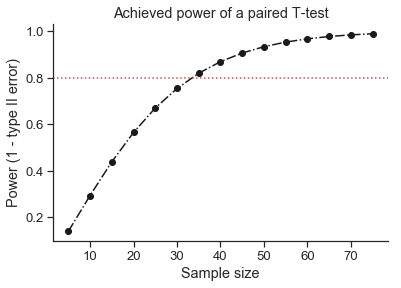

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='notebook', font_scale=1.2)

d = 0.5  # Fixed effect size
n = np.arange(5, 80, 5)  # Incrementing sample size

# Compute the achieved power
pwr = pg.power_ttest(d=d, n=n, contrast='paired', tail='two-sided')

# Start the plot
plt.plot(n, pwr, 'ko-.')
plt.axhline(0.8, color='r', ls=':')
plt.xlabel('Sample size')
plt.ylabel('Power (1 - type II error)')
plt.title('Achieved power of a paired T-test')
sns.despine()